## Import Package

In [1]:
import random
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
import statsmodels.tsa.stattools as sttl

## Environment

In [2]:
class Environment():

    def __init__(
        self,

        # date range
        start_date,
        end_date,

        # name of two stocks
        x_stock_name="ADBE",
        y_stock_name="MSFT",

        # estimation info
        estimation_win=60,

        # trade info
        original_pv=1000,
        transaction_cost=0.001425

    ):
        # prepare testing data
        self.x_test, self.y_test, self.date_test = self.prepare_data(x_stock_name, y_stock_name, start_date, end_date)
        self.ratio_test = self.x_test / self.y_test

        # estimation info
        self.estimation_win = estimation_win
        
        # trade info
        self.original_pv = original_pv
        self.transaction_cost = transaction_cost
        
        # trading log
        self.date_log = []
        self.x_price_log = []
        self.y_price_log = []
        self.action_log = []
        self.pv_log = []
        self.x_vol_log = []
        self.y_vol_log = []

    # prepare testing data
    def prepare_data(self, name1, name2, start_date, end_date):

        # intersect two stocks price on date
        x = pd.read_csv("data/{}.csv".format(name1))
        y = pd.read_csv("data/{}.csv".format(name2))
        x_y = pd.merge(left=x, right=y, how="inner", on="Date")

        i = x_y.index[x_y["Date"] == start_date][0]
        j = x_y.index[x_y["Date"] == end_date][0]
        x_y = x_y.iloc[i:j+1, :]

        # select date range
        x = np.array(x_y["Close_x"])
        y = np.array(x_y["Close_y"])
        t = np.array(x_y["Date"])

        # calculate cointegration p-value of training and testing data
        score, self.test_coint, _ = sttl.coint(x, y)

        return x, y, t


    

    # testing
    def testing(self, agent_model):

        # info
        print("Number of day: ", len(self.x_test))
        print("P-value: ", self.test_coint)

        # trade info initialization
        agent_cash = self.original_pv
        agent_x_count = 0
        agent_y_count = 0
        # baseline_cash = self.original_pv
        # baseline_x_count = 0
        # baseline_y_count = 0

        # begin / end index
        begin_idx = self.estimation_win
        end_idx = len(self.ratio_test)
        current_idx = begin_idx

        # pv history
        agent_pv_history = []
        agent_action_history = []
        # baseline_pv_history = []
        # baseline_action_history = []
        spread_history = []

        # trading loop
        while current_idx != end_idx:

            # today info
            x_price = round(self.x_test[current_idx-1], 6)
            y_price = round(self.y_test[current_idx-1], 6)
            multiplier = round(self.ratio_test[current_idx-1], 6)
            multiplier_constant = 1
            spread_history.append(multiplier * multiplier_constant)

            # calculate baseline and agent pv
            agent_pv = agent_cash + (x_price * agent_x_count) + (y_price * agent_y_count)
            agent_pv_history.append(agent_pv)
            # baseline_pv = baseline_cash + (x_price * baseline_x_count) + (y_price * baseline_y_count)
            # baseline_pv_history.append(baseline_pv)


            # get agent action
            sample = []
            x = np.array(self.x_test[current_idx-self.estimation_win:current_idx])
            y = np.array(self.y_test[current_idx-self.estimation_win:current_idx])
            x_y = np.concatenate((x, y))
            
            x_y_mu = np.mean(x_y)
            x_y_std = np.std(x_y)

            x = (x - x_y_mu) / x_y_std
            y = (y - x_y_mu) / x_y_std

            sample.append(x)
            sample.append(y)
            sample = np.array(sample)
            sample = np.transpose(sample)
            
            agent_action = agent_model.predict(np.reshape(sample, (1, self.estimation_win, 2)))[0]
            action = np.argmax(agent_action)

            agent_action_history.append(action)

            # collect today trading log
            self.date_log.append(self.date_test[current_idx-1])
            self.x_price_log.append(x_price)
            self.y_price_log.append(y_price)
            self.pv_log.append(agent_pv)
            self.action_log.append(action)

            x_vol = 0
            y_vol = 0

            # execute agent action
            # buy 1 x sell ratio y
            if action == 0:

                if agent_x_count < 0 and agent_y_count > 0:
                    agent_cash += agent_x_count * x_price
                    agent_cash -= abs(agent_x_count * x_price) * self.transaction_cost
                    x_vol += -agent_x_count
                    agent_x_count = 0

                    agent_cash += agent_y_count * y_price
                    agent_cash -= agent_y_count * y_price * self.transaction_cost
                    y_vol += -agent_y_count
                    agent_y_count = 0
                    

                # buy 1 x
                agent_cash -= x_price * multiplier_constant
                agent_cash -= x_price  * multiplier_constant * self.transaction_cost 
                x_vol += 1 * multiplier_constant
                agent_x_count += 1 * multiplier_constant

                # sell ratio y
                agent_cash += multiplier * multiplier_constant * y_price 
                agent_cash -= (multiplier * multiplier_constant * y_price) * self.transaction_cost
                y_vol -= multiplier * multiplier_constant
                agent_y_count -= multiplier * multiplier_constant

            # sell 1 x buy ratio y
            elif action == 1:

                if agent_x_count > 0 and agent_y_count < 0:
                    agent_cash += agent_x_count * x_price
                    agent_cash -= agent_x_count * x_price * self.transaction_cost
                    x_vol += -agent_x_count
                    agent_x_count = 0

                    agent_cash += agent_y_count * y_price
                    agent_cash -= abs(agent_y_count * y_price) * self.transaction_cost
                    y_vol += -agent_y_count
                    agent_y_count = 0

                # sell 1 x
                agent_cash += x_price * multiplier_constant
                agent_cash -= x_price  * multiplier_constant * self.transaction_cost
                x_vol -= 1 * multiplier_constant
                agent_x_count -= 1 * multiplier_constant

                # buy ratio y
                agent_cash -= multiplier  * multiplier_constant * y_price
                agent_cash -= (multiplier  * multiplier_constant * y_price) * self.transaction_cost
                y_vol += multiplier * multiplier_constant
                agent_y_count += multiplier * multiplier_constant
            
            # collect trading log
            self.x_vol_log.append(x_vol)
            self.y_vol_log.append(y_vol)
            

            # get baseline action
            # get agent action
            '''
            temp_x = self.x_test[current_idx-self.estimation_win:current_idx]
            temp_y = self.y_test[current_idx-self.estimation_win:current_idx]
            temp_sp = temp_x / temp_y
            temp_sp = (temp_sp - np.mean(temp_sp)) / np.std(temp_sp)

            if temp_sp[-1] >= 1:
                action = 1
            elif temp_sp[-1] <= -1:
                action = 0
            else:
                action = 2

            baseline_action_history.append(action)
            

            # execute baseline action
            # buy 1 x sell ratio y
            if action == 0:

                if baseline_x_count < 0 and baseline_y_count > 0:
                    baseline_cash += baseline_x_count * x_price
                    baseline_cash -= abs(baseline_x_count * x_price) * self.transaction_cost
                    baseline_x_count = 0

                    baseline_cash += baseline_y_count * y_price
                    baseline_cash -= baseline_y_count * y_price * self.transaction_cost
                    baseline_y_count = 0
                    

                # buy 1 x
                baseline_cash -= x_price
                baseline_cash -= x_price * self.transaction_cost 
                baseline_x_count += 1

                # sell ratio y
                baseline_cash += multiplier * y_price
                baseline_cash -= (multiplier * y_price) * self.transaction_cost
                baseline_y_count -= multiplier

            # sell 1 x buy ratio y
            elif action == 1:

                if baseline_x_count > 0 and baseline_y_count < 0:
                    baseline_cash += baseline_x_count * x_price
                    baseline_cash -= baseline_x_count * x_price * self.transaction_cost
                    baseline_x_count = 0

                    baseline_cash += baseline_y_count * y_price
                    baseline_cash -= abs(baseline_y_count * y_price) * self.transaction_cost
                    baseline_y_count = 0

                # sell 1 x
                baseline_cash += x_price
                baseline_cash -= x_price * self.transaction_cost
                baseline_x_count -= 1

                # buy ratio y
                baseline_cash -= multiplier * y_price
                baseline_cash -= (multiplier * y_price) * self.transaction_cost
                baseline_y_count += multiplier
            '''

            
            current_idx += 1
    

        return agent_pv_history, agent_action_history, spread_history

## DQN Agent

## Main

In [19]:
STATE_DIM = 180

In [20]:
env = Environment(
    # date range
    start_date="2018-01-02",
    end_date="2018-12-31",

    # name of two stocks
    x_stock_name="MA",
    y_stock_name="CMCSA",

    # estimation / episode info
    estimation_win=STATE_DIM,

    # trade info
    original_pv=1000,
    transaction_cost=0.001425
)

## Testing

In [21]:
testing_dict = {}

In [22]:
for idx in range(0, 2100, 100):

    agent_pv, agent_action, spread = env.testing(models.load_model("MA_CMCSA_2018_DDDQN_BOTH_004/main_model_{}_episode.hdf5".format(str(idx))))

    testing_dict[idx] = {
        "agent_pv": agent_pv,
        "agent_action": agent_action,
    }

Number of day:  251
P-value:  0.6899026421054487
Number of day:  251
P-value:  0.6899026421054487
Number of day:  251
P-value:  0.6899026421054487
Number of day:  251
P-value:  0.6899026421054487
Number of day:  251
P-value:  0.6899026421054487
Number of day:  251
P-value:  0.6899026421054487
Number of day:  251
P-value:  0.6899026421054487
Number of day:  251
P-value:  0.6899026421054487
Number of day:  251
P-value:  0.6899026421054487
Number of day:  251
P-value:  0.6899026421054487
Number of day:  251
P-value:  0.6899026421054487
Number of day:  251
P-value:  0.6899026421054487
Number of day:  251
P-value:  0.6899026421054487
Number of day:  251
P-value:  0.6899026421054487
Number of day:  251
P-value:  0.6899026421054487
Number of day:  251
P-value:  0.6899026421054487
Number of day:  251
P-value:  0.6899026421054487
Number of day:  251
P-value:  0.6899026421054487
Number of day:  251
P-value:  0.6899026421054487
Number of day:  251
P-value:  0.6899026421054487
Number of day:  251


## Analyze

In [23]:
def pv_sharpe_ratio(pv):
    changePerDay = []
    lastValue = 1
    for value in pv:
        changePerDay.append((value-lastValue)/lastValue)
        lastValue = value

    changePerDay.pop(0)
    avgValue = sum(changePerDay) / len(changePerDay)
    std = statistics.stdev(changePerDay)

    # convert into annual sharpe ration
    return (avgValue/std) * (len(pv) ** 0.5)

def pv_mdd(pv):
    arr = np.array(pv)
    temp_arr = arr[1:]
    argmin = temp_arr.argmin()
    previousWin = arr[0:argmin]
    argmax = previousWin.argmax()
    return (pv[argmax] - pv[argmin]) / pv[argmax]

def pv_return(pv):
    return (pv[-1] - pv[0]) / pv[0]

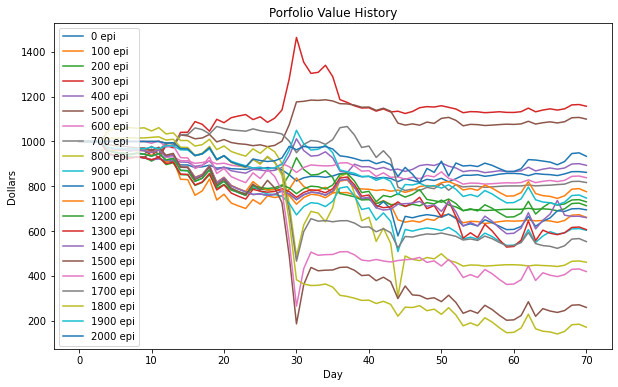

In [24]:
plt.figure(figsize=(10, 6))
plt.title("Porfolio Value History")
plt.xlabel("Day")
plt.ylabel("Dollars")

data = []

for key, value in testing_dict.items():
    
    plt.plot(value["agent_pv"], label="{} epi".format(key))
    pv_history = value["agent_pv"]
    
    temp = []
    temp.append(pv_return(pv_history))
    temp.append(pv_sharpe_ratio(pv_history))
    temp.append(pv_mdd(pv_history))
    data.append(temp)
        
df = pd.DataFrame(data, columns=['return', 'sr', 'mdd'])

plt.legend(loc="upper left")

In [26]:
pv_return(testing_dict[500]['agent_pv'])

0.09983643032993586

In [25]:
df

,return,sr,mdd
0,-0.138140,-1.476269,0.174262
1,-0.338959,-1.339370,0.358119
2,-0.287035,-1.361235,0.303286
3,0.157379,0.665593,0.067392
4,-0.106725,-0.548766,0.136943
5,0.099836,0.641720,0.051644
6,-0.161895,-1.536007,0.174188
7,-0.183547,-0.801613,0.262676
8,-0.539361,-0.306655,0.487576
9,-0.396603,-0.967520,0.356848


In [27]:
import pickle
with open('both.pickle', 'wb') as f:
    pickle.dump(testing_dict[500]['agent_pv'], f)

In [ ]:
action1_filter = np.array(testing_dict[800]["agent_action"]) == 1
action2_filter = np.array(testing_dict[800]["agent_action"]) == 0

In [ ]:
action1_filter = action1_filter.astype("float")
action2_filter = action2_filter.astype("float")

In [ ]:
rgba_color1 = np.zeros((len(action1_filter),4))
rgba_color1[:,0] = 1.0
rgba_color1[:, 3] = action1_filter

rgba_color2 = np.zeros((len(action2_filter),4))
rgba_color2[:,1] = 1.0
rgba_color2[:, 3] = action2_filter

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Porfolio Value History")
plt.xlabel("Day")
plt.ylabel("Spread")

plt.scatter(np.arange(len(spread)), spread, color=rgba_color1, s=10)

plt.scatter(np.arange(len(spread)), spread, color=rgba_color2, s=10)

plt.plot(spread)